In [15]:
import sympy as sp
import jax.numpy as np
import matplotlib.pyplot as plt

from util.interfaces import Config, EqInfo, Hyperparameters, VarInfo
from main import run

Burgers' equation

$
\displaystyle \frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} - \frac{0.01}{\pi} \frac{\partial^2 u}{\partial x^2} = 0
$

$
\displaystyle u(0, x) = -\sin(\pi x) \\
\displaystyle u(t, -1) = u(t, 1) = 0
$

In [16]:
config = Config(
  eq = EqInfo(
    name = 'u',
    function = lambda s: s.dudt + s.u * s.dudx - (0.01 / sp.pi) * s.d2udx2,
  ),
  vars = {
    't': VarInfo(bounds=(0, 1)),
    'x': VarInfo(bounds=(-1, 1))
  },
  conditions = [
      (2., lambda s: s.u.subs(s.t, 0) + sp.sin(sp.pi * s.x)),
      (2., lambda s: s.u.subs(s.x, -1)),
      (2., lambda s: s.u.subs(s.x, 1)),
  ],
  preoperations = [
    lambda t, x: 0,
    lambda t, x: 1,
    lambda t, x: t,
    lambda t, x: x,
    lambda t, x: -x,
    lambda t, x: sp.exp(x),
    lambda t, x: x * t,
    lambda t, x: sp.exp(x) * t,
  ],
  operations = [
    lambda z, _: 0,
    lambda z, _: 1,
    lambda z, _: z,
    lambda z, _: z + 1,
    lambda z, _: -z,
    lambda z, _: sp.exp(z),
  ],
  hyperparameters = Hyperparameters(
    lr = 0.001,
    penalty = 1,
    nodecount = 5,
  ),
  epochs = 128,
  samples = 512,
  batchsize = 64,
  verbosity = 1,
)

In [17]:
network, best, loss_histories = run(config)

23:27:40.178 [INFO] Constructed symbolic model
23:27:41.482 [INFO] Constructed loss equation
23:27:43.682 [INFO] Constructed JAXified model
23:27:49.540 [INFO] Epoch: 1, Loss: 10.4907131195
23:27:49.400 [INFO] Epoch: 10, Loss: 4.4665150642
23:27:49.778 [INFO] Epoch: 20, Loss: 1.6390058994
23:27:50.146 [INFO] Epoch: 30, Loss: 0.9750304222
23:27:50.519 [INFO] Epoch: 40, Loss: 0.8910182714
23:27:50.886 [INFO] Epoch: 50, Loss: 0.8527182937
23:27:51.256 [INFO] Epoch: 60, Loss: 0.8845673800
23:27:51.635 [INFO] Epoch: 70, Loss: 0.8295177221
23:27:52.410 [INFO] Epoch: 80, Loss: 0.8458420038
23:27:52.459 [INFO] Epoch: 90, Loss: 0.8414582014
23:27:52.841 [INFO] Epoch: 100, Loss: 0.8219352961
23:27:53.197 [INFO] Epoch: 110, Loss: 0.7714130282
23:27:53.570 [INFO] Epoch: 120, Loss: 0.8232488632
23:27:53.935 [INFO] Epoch: 128, Loss: 0.8191010952
23:27:53.936 [INFO] Pruning weights (1 / 58)
23:27:54.140 [INFO] Shed 0.05971314758062363 weight
23:27:54.171 [INFO] Constructed symbolic model
23:27:55.379

Nothing more to prune!


$\displaystyle 0.130458233489587 t x + 0.16775517978791 x - 1.08303360615556 e^{0.219613581895828 x} - 0.142374154435032 e^{x} + 0.431302160024643 e^{0.365474700927734 t x} + 0.870762419457051$

Best loss: 0.6208204030990601


In [18]:
prediction_best = best.model.subs(zip(best.alphas, best.W))
print(sp.latex(prediction_best))

0.130458233489587 t x + 0.16775517978791 x - 1.08303360615556 e^{0.219613581895828 x} - 0.142374154435032 e^{x} + 0.431302160024643 e^{0.365474700927734 t x} + 0.870762419457051


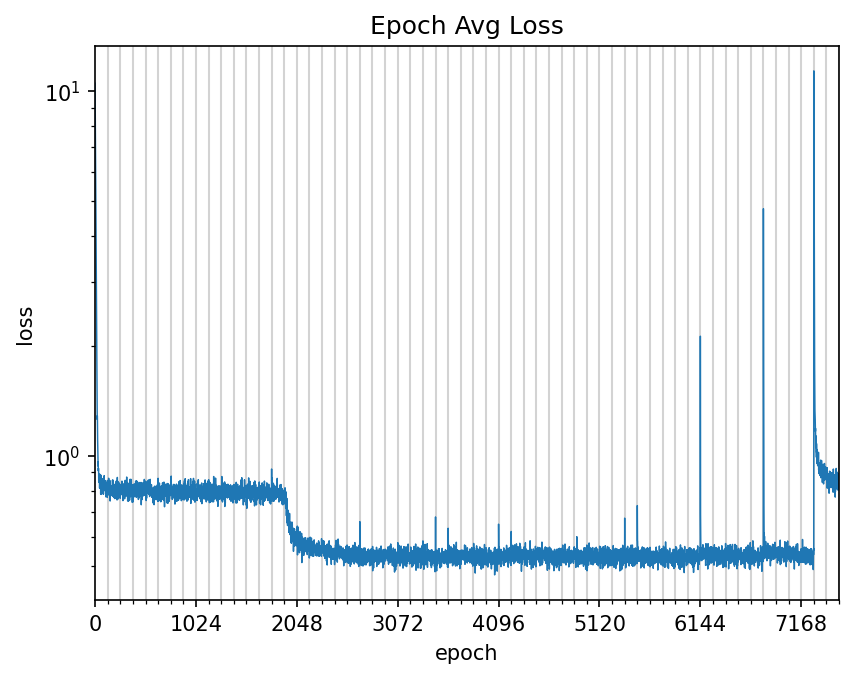

In [19]:
loss_history = []
prunepoints = []

for pruneepoch in loss_histories:
  count = 0 if len(prunepoints) == 0 else prunepoints[len(prunepoints)-1]
  for epoch in pruneepoch:
    loss_history += [np.average(np.array(epoch))]
    count += 1
  prunepoints += [count]

plt.title('Epoch Avg Loss')
plt.xlabel('epoch')
plt.xlim((0, prunepoints[len(prunepoints) - 1]))
# plt.ylim((min(loss_history)*0.5, 2))
plt.gcf().gca().xaxis.set_major_locator(plt.MultipleLocator(1024))
plt.gcf().gca().xaxis.set_minor_locator(plt.MultipleLocator(128))
plt.yscale('log')
plt.ylabel('loss')
for prunepoint in prunepoints:
  plt.axvline(prunepoint, color='lightgrey', linewidth=1)
plt.plot(loss_history, linewidth=0.7)
plt.gcf().set_dpi(150)
plt.show()

In [26]:
x = network.symbols.x
t = network.symbols.t
pred_fn = sp.lambdify([x, t], prediction_best)

In [41]:
u = prediction_best
dudt = prediction_best.diff(t)
dudx = prediction_best.diff(x)
d2udx2 = prediction_best.diff(x, 2)

error = dudt + u * dudx - (0.01 / sp.pi) * d2udx2
error_c1 = u.subs(t, 0) + sp.sin(sp.pi * x)
error_c2 = u.subs(x, -1)
error_c3 = u.subs(x, 1)
errorlambdified = sp.lambdify([t, x], error**2 + error_c1**2 + error_c2**2 + error_c3**2, modules='jax')
tt, xx = np.meshgrid(np.arange(*config.vars['t'].bounds, 0.01), np.arange(*config.vars['x'].bounds, 0.01))
np.mean(errorlambdified(tt, xx)).item()

0.4428160488605499

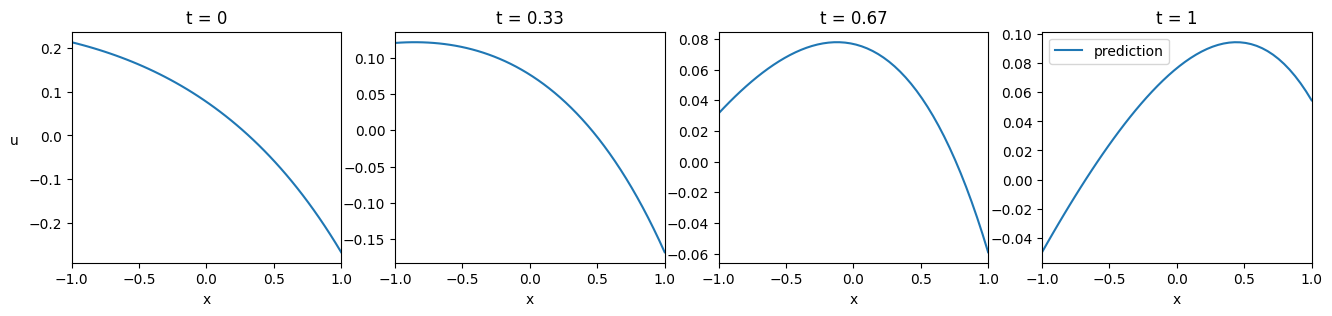

In [22]:
x = np.linspace(*(config.vars['x'].bounds), 50)
fig, axs = plt.subplots(1, 4, figsize=(16, 3))
for t_try, ax in zip([0, 0.33, 0.67, 1], axs):
  ax.set_title(f't = {t_try}')
  ax.plot(x, pred_fn(x, t_try), label='prediction')
  ax.set_xlim((config.vars['x'].bounds))
  ax.set_xlabel('x')
axs[0].legend()
axs[0].set_ylabel('u', rotation=0, labelpad=10)
plt.show()